# Image Classification challange AN2DL Politecnico di Milano 2022
In this notebook there is the definition of the model used for the [AN2DL image classification challange 2022](https://web.archive.org/web/20221129163804/https://codalab.lisn.upsaclay.fr/competitions/8522).

We expect this file to run in a directory where there is a subdirectory with the data at `data/training_data_final` or `data/training_dataset_homework1.zip` (if using Colab you need the zip).

## Notebook settings
Here the general settings of the notebook are defined.
- IS_COLAB: True if you are running the notebook from Colab
- COLAB_BASE_DIR: The base directory in Google Drive if you are using Colab
- USE_WHOLE_DATASET: If false use a validation split with early stopping for the training, if true you need to specify the number of epochs and the whole dataset is used for training

In [ ]:
IS_COLAB = True
COLAB_BASE_DIR = '/gdrive/MyDrive/2022_AN2DL/Homework1/' # Change this!
USE_WHOLE_DATASET = False # if True do not perform validation and analysis, just train with all the data

### Connect to Drive

In [ ]:
if IS_COLAB:
  from google.colab import drive
  drive.mount('/gdrive')

Mounted at /gdrive


### Import Libraries

In [ ]:
if IS_COLAB:
  !pip install tensorflow==2.10
  !pip install keras-cv

In [ ]:
import tensorflow as tf
import keras_cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from shutil import copyfile, make_archive, unpack_archive
import random
import sklearn as scikit_learn
from datetime import datetime

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


### Seed for reproducibility

In [ ]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Dataset

Load the data in Tensorflow's datasets.

In [ ]:
ROOT_DIR = os.getcwd()
DATA_DIR = 'data/training_data_final'

if not os.path.exists('data'):
    os.mkdir("data")

if not os.path.exists(DATA_DIR):
  if IS_COLAB:
    copyfile(COLAB_BASE_DIR + 'data/training_dataset_homework1.zip', 'data/training_dataset_homework1.zip')
  if os.path.isfile("data/training_dataset_homework1.zip"):
    unpack_archive("data/training_dataset_homework1.zip", "data")
  else:
    raise RuntimeError("please unzip data/training_dataset_homework1.zip")

In [ ]:
VALIDATION_SPLIT = 0.125
BATCH_SIZE = 64

IMG_SIZE = (96,96)
IMG_SHAPE = IMG_SIZE + (3,)
N_CLASSES = 8

if USE_WHOLE_DATASET:
    complete_set = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=seed,
    )
else:
    training_set = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        labels='inferred',
        label_mode='categorical',
        class_names = None,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=(96,96),
        shuffle=True,
        seed=seed,
        validation_split=VALIDATION_SPLIT,
        subset='training'
    )

    validation_set = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        labels='inferred',
        label_mode='categorical',
        class_names = None,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=(96,96),
        shuffle=True,
        seed=seed,
        validation_split=VALIDATION_SPLIT,
        subset='validation'
    )


Found 3542 files belonging to 8 classes.
Using 3100 files for training.
Found 3542 files belonging to 8 classes.
Using 442 files for validation.


### Autotune

Improve the dataset performances.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

if USE_WHOLE_DATASET:
  complete_set = complete_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
else:
  training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

#### Cutmix and Mixup
We used the [CutMix regularization strategy](https://arxiv.org/abs/1905.04899) and the Mixup stragegy (one of the two for each image).

In [ ]:
def preprocess(img, label):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.cast(img, tf.float32)
    return {"images": img, "labels": label}

def prep_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels
    
def cutmix_or_mixup(samples):
    if tf.random.uniform(()) > 0.5:
        samples = keras_cv.layers.CutMix()(samples)
    else:
        samples = keras_cv.layers.MixUp()(samples)
    return samples

if USE_WHOLE_DATASET:
  complete_set_cm = complete_set.map(preprocess).map(cutmix_or_mixup).map(prep_for_model)
else:
  training_set_cm = training_set.map(preprocess).map(cutmix_or_mixup).map(prep_for_model)

#### Other data augmentation in the pipeline

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(factor=0.35, fill_mode='reflect'),
  tf.keras.layers.RandomZoom(height_factor=-0.15),
], name='data_augmentation')

Plot Data Augmentation results:

In [ ]:
if USE_WHOLE_DATASET:
  image_batch, label_batch = next(iter(complete_set_cm))
else:
  image_batch, label_batch = next(iter(training_set_cm))

plt.figure(figsize=(10, 10))
first_image = image_batch[0]
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
  plt.imshow(augmented_image[0] / 255)
  plt.axis('off')

## Model
Here we will define our model.

We decided to use the ConvNeXtLarge network with the weights initialized to the imagenet dataset. However, we retrained the whole network (excluding batch normalization layers) using the original weights only as initialization.

Our strategy still followed the one of fine tuning, even thought we retrained the whole model, because it yielded better results:
1. Train only the classification part
2. Retrain the whole network togheter

### Model definition

General hyperparameters:

In [ ]:
if USE_WHOLE_DATASET:
  model_EPOCHS = 40
else:
  model_MAX_EPOCHS = 200
  model_EARLY_STOPPING_PATIENCE = 19

model_LEARNING_RATE = 1e-3
model_OPTIMIZER = tf.keras.optimizers.Adam(model_LEARNING_RATE)
model_LOSS = tf.keras.losses.CategoricalCrossentropy()

We use the ConvNextLarge supernet, initialized with the imagenet weights.

In [ ]:
model_supernet = tf.keras.applications.convnext.ConvNeXtLarge(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights='imagenet'
)
model_supernet.trainable = False

785596384/785596384 [==============================] - 4s 0us/step


We noticed that the classes are imbalanced so we used [class weighting](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator()
data = datagen.flow_from_directory(DATA_DIR)
unique = np.unique(data.classes, return_counts=True)

class_weights = scikit_learn.utils.compute_class_weight('balanced', classes = np.unique(data.classes), y=data.classes)

class_weights_dict = dict(enumerate(class_weights.flatten()))

print(class_weights_dict)

Found 3542 images belonging to 8 classes.
{0: 2.3803763440860215, 1: 0.8322368421052632, 2: 0.8597087378640776, 3: 0.8664383561643836, 4: 0.833804143126177, 5: 1.9943693693693694, 6: 0.824487895716946, 7: 0.8715551181102362}


We used anti-overfitting techniques such as dropout and L1L2 regularization.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SHAPE, name="input_layer"),
    data_augmentation,
    tf.keras.layers.Lambda(tf.keras.applications.convnext.preprocess_input, name='supernet_preprocessing'),
    model_supernet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.39),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(1e-3), kernel_initializer=tfk.initializers.HeUniform(seed)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(1e-3), kernel_initializer=tfk.initializers.HeUniform(seed)),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(N_CLASSES, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotUniform(seed), name='output_layer')
], name = "ConvNextLarge_final_2nd")

In [ ]:
model.compile(loss=model_LOSS, optimizer=model_OPTIMIZER, metrics='accuracy')
model.summary()

Model: "ConvNextLarge_final_2nd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 96, 96, 3)        0         
 al)                                                             
                                                                 
 supernet_preprocessing (Lam  (None, 96, 96, 3)        0         
 bda)                                                            
                                                                 
 convnext_large (Functional)  (None, 3, 3, 1536)       196230336 
                                                                 
 flatten (Flatten)           (None, 13824)             0         
                                                                 
 dropout (Dropout)           (None, 13824)             0         
                                                                 
 dense (Dense)               (None, 1024)  

### Classification head first training

In [ ]:
if USE_WHOLE_DATASET:
  model_history = model.fit(
      complete_set_cm,
      epochs=model_EPOCHS,
      class_weight = class_weights_dict
  )
else:
  model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=model_EARLY_STOPPING_PATIENCE, restore_best_weights=True)
  model_history = model.fit(
      training_set_cm,
      validation_data = validation_set,
      epochs = model_MAX_EPOCHS,
      callbacks = [model_early_stopping],
      class_weight = class_weights_dict
  )

Epoch 1/200


49/49 [==============================] - 284s 2s/step - loss: 96.0844 - accuracy: 0.2855 - val_loss: 37.0686 - val_accuracy: 0.5181
Epoch 2/200
49/49 [==============================] - 36s 734ms/step - loss: 21.4093 - accuracy: 0.3935 - val_loss: 12.9503 - val_accuracy: 0.4615
Epoch 3/200
49/49 [==============================] - 39s 792ms/step - loss: 11.0188 - accuracy: 0.3735 - val_loss: 9.0024 - val_accuracy: 0.5385
Epoch 4/200
49/49 [==============================] - 37s 758ms/step - loss: 8.3340 - accuracy: 0.4129 - val_loss: 6.8614 - val_accuracy: 0.6109
Epoch 5/200
49/49 [==============================] - 37s 758ms/step - loss: 6.8633 - accuracy: 0.4403 - val_loss: 5.8204 - val_accuracy: 0.6312
Epoch 6/200
49/49 [==============================] - 37s 748ms/step - loss: 6.0124 - accuracy: 0.4294 - val_loss: 5.1210 - val_accuracy: 0.5747
Epoch 7/200
49/49 [==============================] - 37s 757ms/step - loss: 5.3464 - accuracy: 0.4635 - val_loss: 4.5430 - val_accuracy: 0.6425
E

Plot the results:

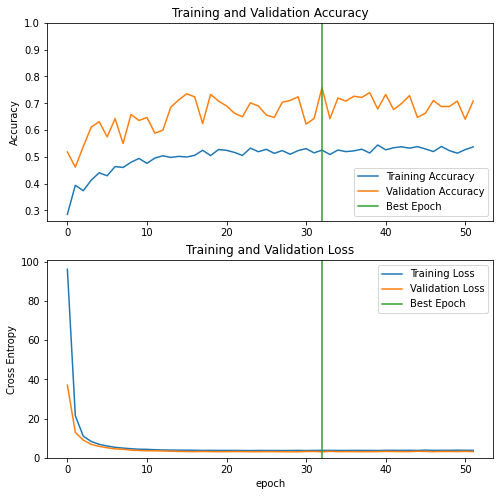

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([model_early_stopping.best_epoch,model_early_stopping.best_epoch], plt.ylim(), label='Best Epoch')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,max(plt.ylim())])
plt.plot([model_early_stopping.best_epoch,model_early_stopping.best_epoch], plt.ylim(), label='Best Epoch')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### General retraining

In [ ]:
if USE_WHOLE_DATASET:
  ft_model_EPOCHS = 200
else:
  ft_model_MAX_EPOCHS = 200
  ft_model_EARLY_STOPPING_PATIENCE = 23

ft_model_LEARNING_RATE = 5.2e-5
ft_model_OPTIMIZER = tf.keras.optimizers.Adam(ft_model_LEARNING_RATE)
ft_model_LOSS = tf.keras.losses.CategoricalCrossentropy()
ft_model_UNFREEZE = 670 # Note: if greater than the number of layers in the model, the whole model will be unfreezed

#### Copy model

In [ ]:
ft_model = model

ft_model.compile(
    optimizer=ft_model_OPTIMIZER,
    loss=ft_model_LOSS,
    metrics=['accuracy']
)
ft_model.set_weights(model.get_weights())
ft_model.summary()
print("Number of layers in the supernet: ", len(ft_model.get_layer(model_supernet.name).layers))

Model: "ConvNextLarge_final_2nd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 96, 96, 3)        0         
 al)                                                             
                                                                 
 supernet_preprocessing (Lam  (None, 96, 96, 3)        0         
 bda)                                                            
                                                                 
 convnext_large (Functional)  (None, 3, 3, 1536)       196230336 
                                                                 
 flatten (Flatten)           (None, 13824)             0         
                                                                 
 dropout (Dropout)           (None, 13824)             0         
                                                                 
 dense (Dense)               (None, 1024)  

#### Unfreeze layers
Here we unfreeze the whole model, with the exception of batch normalization layers.

In [ ]:
ft_model.get_layer(model_supernet.name).trainable = True

unfreezed = 0
for i in reversed(range(len(ft_model.get_layer(model_supernet.name).layers))):
  layer = ft_model.get_layer(model_supernet.name).layers[i]
  if unfreezed < ft_model_UNFREEZE and not isinstance(layer, tf.keras.layers.BatchNormalization):
      unfreezed += 1
      layer.trainable = True
  else:
    layer.trainable = False
  
  print(i, layer.name, layer.trainable)


ft_model.summary()

294 layer_normalization True
293 tf.__operators__.add_35 True
292 convnext_large_stage_3_block_2_identity True
291 convnext_large_stage_3_block_2_layer_scale True
290 convnext_large_stage_3_block_2_pointwise_conv_2 True
289 convnext_large_stage_3_block_2_gelu True
288 convnext_large_stage_3_block_2_pointwise_conv_1 True
287 convnext_large_stage_3_block_2_layernorm True
286 convnext_large_stage_3_block_2_depthwise_conv True
285 tf.__operators__.add_34 True
284 convnext_large_stage_3_block_1_identity True
283 convnext_large_stage_3_block_1_layer_scale True
282 convnext_large_stage_3_block_1_pointwise_conv_2 True
281 convnext_large_stage_3_block_1_gelu True
280 convnext_large_stage_3_block_1_pointwise_conv_1 True
279 convnext_large_stage_3_block_1_layernorm True
278 convnext_large_stage_3_block_1_depthwise_conv True
277 tf.__operators__.add_33 True
276 convnext_large_stage_3_block_0_identity True
275 convnext_large_stage_3_block_0_layer_scale True
274 convnext_large_stage_3_block_0_pointw

#### Training

In [ ]:
ft_model.compile(
    optimizer=ft_model_OPTIMIZER,
    loss=ft_model_LOSS,
    metrics=['accuracy']
)
ft_model.summary()

Model: "ConvNextLarge_final_2nd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 96, 96, 3)        0         
 al)                                                             
                                                                 
 supernet_preprocessing (Lam  (None, 96, 96, 3)        0         
 bda)                                                            
                                                                 
 convnext_large (Functional)  (None, 3, 3, 1536)       196230336 
                                                                 
 flatten (Flatten)           (None, 13824)             0         
                                                                 
 dropout (Dropout)           (None, 13824)             0         
                                                                 
 dense (Dense)               (None, 1024)  

In [ ]:
if USE_WHOLE_DATASET:
  ft_history = ft_model.fit(
    complete_set,
    epochs=ft_model_EPOCHS,
    initial_epoch=model_EPOCHS,
    class_weight = class_weights_dict
  )
else:
  ft_total_epochs =  model_early_stopping.best_epoch + ft_model_MAX_EPOCHS

  ft_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=ft_model_EARLY_STOPPING_PATIENCE, restore_best_weights=True)

  ft_history = ft_model.fit(
      training_set_cm,
      epochs=ft_total_epochs,
      initial_epoch=model_early_stopping.best_epoch,
      validation_data=validation_set,
      callbacks = [ft_early_stopping],
      class_weight = class_weights_dict
  )

Epoch 33/232


49/49 [==============================] - 116s 2s/step - loss: 2.3330 - accuracy: 0.5861 - val_loss: 1.4425 - val_accuracy: 0.7851
Epoch 34/232
49/49 [==============================] - 79s 2s/step - loss: 2.0132 - accuracy: 0.6497 - val_loss: 1.3125 - val_accuracy: 0.8077
Epoch 35/232
49/49 [==============================] - 77s 2s/step - loss: 1.9365 - accuracy: 0.6710 - val_loss: 1.3141 - val_accuracy: 0.7783
Epoch 36/232
49/49 [==============================] - 78s 2s/step - loss: 1.9044 - accuracy: 0.6900 - val_loss: 1.2273 - val_accuracy: 0.8281
Epoch 37/232
49/49 [==============================] - 79s 2s/step - loss: 1.8264 - accuracy: 0.7074 - val_loss: 1.1402 - val_accuracy: 0.8665
Epoch 38/232
49/49 [==============================] - 78s 2s/step - loss: 1.7940 - accuracy: 0.7123 - val_loss: 1.0707 - val_accuracy: 0.8756
Epoch 39/232
49/49 [==============================] - 79s 2s/step - loss: 1.7334 - accuracy: 0.7245 - val_loss: 1.0204 - val_accuracy: 0.8824
Epoch 40/232
49/49

Plot the results:

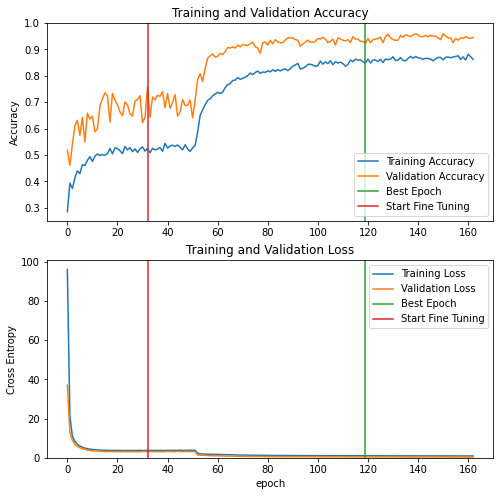

In [ ]:
acc += ft_history.history['accuracy']
if not USE_WHOLE_DATASET:
  val_acc += ft_history.history['val_accuracy']

loss += ft_history.history['loss']
if not USE_WHOLE_DATASET:
  val_loss += ft_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
if not USE_WHOLE_DATASET:
  plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
if not USE_WHOLE_DATASET:
  plt.plot([ft_early_stopping.best_epoch,ft_early_stopping.best_epoch],
         plt.ylim(), label='Best Epoch')
if not USE_WHOLE_DATASET:
  plt.plot([model_early_stopping.best_epoch, model_early_stopping.best_epoch],
          plt.ylim(), label='Start Fine Tuning')
else:
  plt.plot([model_EPOCHS, model_EPOCHS],
          plt.ylim(), label='Start Fine Tuning')

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
if not USE_WHOLE_DATASET:
  plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,max(plt.ylim())])
if not USE_WHOLE_DATASET:
  plt.plot([ft_early_stopping.best_epoch,ft_early_stopping.best_epoch],
         plt.ylim(), label='Best Epoch')
if not USE_WHOLE_DATASET:
  plt.plot([model_early_stopping.best_epoch, model_early_stopping.best_epoch],
          plt.ylim(), label='Start Fine Tuning')
else:
  plt.plot([model_EPOCHS, model_EPOCHS],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Save the model and create submission

In [ ]:
SUBMISSION_DIR = f'submission-{datetime.today().strftime("%Y-%m-%d-%H-%M-%S")}'
os.mkdir(SUBMISSION_DIR)

with open(os.path.join(SUBMISSION_DIR, "metadata"), "a") as f:
  pass

We use the Test Time Augmentation ensemble technique to improve the performance of our model.

Specifically, this technique involves creating multiple augmented copies of each image in the test set,
having the model make a prediction for each, then returning an ensemble of those predictions.

In our specific case from each image we create 6 images:
- The image itself
- An image flipped on the hirizontal axis
- 4 images, shifted of 9 pixels (10%), one for each of the 4 directions

In [ ]:
%%writefile $SUBMISSION_DIR/model.py
import os

import tensorflow as tf
import numpy as np


class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, "SubmissionModel"))

    def predict(self, X):
        """
        We use the Test Time Augmentation ensemble technique to improve the performance of our model.

        Specifically, this technique involves creating multiple augmented copies of each image in the test set,
        having the model make a prediction for each, then returning an ensemble of those predictions.

        In our specific case from each image we create 6 images:
            - The image itself
            - An image flipped on the hirizontal axis
            - 4 images, shifted of 9 pixels (10%), one for each of the 4 directions
        """
        # In this challange the input (X) should be a tensor but we prepared the file to accept other kinds of inputs
        if tf.is_tensor(X):
            # We can call directly self.tta_prediction(X) because it will perform the operation on the tensor
            yhat = self.tta_prediction(X)
            return yhat
        elif hasattr(X, "_batch_size"):
            # X could be a batch so we need to unbatch it
            images, _ = tuple(zip(*X.unbatch()))
        else:
            # General fallback case
            images, _ = tuple(zip(*X))

        # Perform the tta for every image and return the resulting tensor
        yhats = list()
        for i in range(len(images)):
            yhat = self.tta_prediction(images[i])
            yhats.append(yhat)

        return tf.convert_to_tensor(yhats)

    def tta_prediction(self, image):
        images = list(
            [
                image,
                np.flip(image, axis=1),
                np.roll(image, -9, axis=0),
                np.roll(image, -9, axis=1),
                np.roll(image, 9, axis=0),
                np.roll(image, 9, axis=1),
            ]
        )

        preds = [self.model.predict(x, verbose=0) for x in images]
        sums = tf.reduce_sum(preds, axis=0)
        tta_pred = tf.argmax(sums, axis=-1)

        return tta_pred

In [ ]:
ft_model.save(SUBMISSION_DIR + '/SubmissionModel')
make_archive(SUBMISSION_DIR, 'zip', SUBMISSION_DIR)

In [ ]:
if IS_COLAB:
  copyfile(SUBMISSION_DIR + '.zip', COLAB_BASE_DIR + SUBMISSION_DIR + '.zip')

  # Close colab connection
  from google.colab import runtime
  runtime.unassign()